Esta notebook contiene bloques de código útiles para realizar Q-learning en el entorno "Descent Env"

In [1]:
import numpy as np
from descent_env import DescentEnv
from q_learning_agent import QLearningAgent
from q_learning_stochastic_agent import QLearningStochasticAgent

pygame 2.5.2 (SDL 2.28.3, Python 3.10.8)
Hello from the pygame community. https://www.pygame.org/contribute.html
Using Python-based geo functions


In [2]:
# Cambiar render_mode a rgb_array para entrenar/testear
from env_recorder_wrapper import VideoRecorderWrapper 
import wandb
env = DescentEnv(render_mode='rgb_array')

Reading config from /Users/agustinvarela/bluesky/settings.cfg
Reading magnetic variation data
Loading global navigation database...
Reading cache: /Users/agustinvarela/bluesky/cache/navdata.p
Successfully loaded OpenAP performance model
Failed to load BADA performance model
Successfully loaded legacy performance model
Successfully loaded plugin AREA
Successfully loaded plugin DATAFEED


Observation Space

In [3]:
env.observation_space

Dict('altitude': Box(-inf, inf, (1,), float64), 'runway_distance': Box(-inf, inf, (1,), float64), 'target_altitude': Box(-inf, inf, (1,), float64), 'vz': Box(-inf, inf, (1,), float64))

Action Space

In [4]:
env.action_space

Box(-1.0, 1.0, (1,), float64)

Discretización de los estados

**Nota:** es importante que chequeen el espacio de observación y el espacio de acción del entorno. Los números usados son ejemplos y pueden no ser correctos

In [5]:
altitude_space = np.concatenate([
    np.linspace(0, 0.2, 2, endpoint=False),
    np.linspace(0.2, 0.8, 6),
    np.linspace(0.8, 1.3, 3),
    np.linspace(1.3, 2.3,3),
    np.linspace(2.3, 2.5, 3)]) 

vertical_velocity_space = np.linspace(-2.7,2.5, 3)

target_altitude_space = np.concatenate([
    np.linspace(0,0.2, 2, endpoint=False),
    np.linspace(0.2, 0.8, 12),
    np.linspace(0.8, 0.9, 2, )])

#runway_distance_space = np.concatenate([
#    np.linspace(-0.6, -0.5, 3, endpoint=False),
#    np.linspace(-0.5, 0.1, 8),
#    np.linspace(0.1, 1, 3)])

runway_distance_space = np.concatenate([
    np.linspace(-0.3, -0.01, 3, endpoint=False),  # post-pista (negativos)
    np.linspace(-0.01, 0.1, 6),                   # justo antes y sobre pista
    np.linspace(0.1, 0.5, 4),                     # aproximación cercana
    np.linspace(0.5, 1.2, 3)                      # aproximación lejana
])
#print("altitude_space:", altitude_space)
#print("vertical_velocity_space:", vertical_velocity_space)
#print("target_altitude_space:", target_altitude_space)
#print("runway_distance_space:", runway_distance_space)


#import gymnasium as gym
#from descent_env import DescentEnv
#import numpy as np
#import random
#
#env = DescentEnv(render_mode="human") 
#obs, info = env.reset()
#
#num_episodes = 5 
#max_steps_per_episode = 500 
#
#all_altitudes = []
#all_vertical_velocities = []
#all_target_altitudes = []
#all_runway_distances = []
#
#for episode in range(num_episodes):
#    obs, info = env.reset()
#    done = False
#    steps = 0
#    print(f"\n--- Episodio {episode + 1} ---")
#    while not done and steps < max_steps_per_episode:
#        # Aquí generas una acción aleatoria válida para tu entorno
#        actions = [-1.0, -0.5, 0.0, 0.5, 1.0] # Acciones discretas sugeridas en el notebook
#        action = np.array([random.choice(actions)])
#
#        obs, reward, done, truncated, info = env.step(action)
#
#        # Recolectar datos
#        all_altitudes.append(obs["altitude"][0])
#        all_vertical_velocities.append(obs["vz"][0])
#        all_target_altitudes.append(obs["target_altitude"][0])
#        all_runway_distances.append(obs["runway_distance"][0])
#        steps += 1
#        
#    env.render()
#    env.close()
#
## Analizar los datos recolectados
#print("\n--- Análisis de rangos observados ---")
#print(f"Altitud: Min={np.min(all_altitudes):.2f}, Max={np.max(all_altitudes):.2f}")
#print(f"Velocidad Vertical: Min={np.min(all_vertical_velocities):.2f}, Max={np.max(all_vertical_velocities):.2f}")
#print(f"Altitud Objetivo: Min={np.min(all_target_altitudes):.2f}, Max={np.max(all_target_altitudes):.2f}")
#print(f"Distancia Pista: Min={np.min(all_runway_distances):.2f}, Max={np.max(all_runway_distances):.2f}")
#"""

In [6]:
actions = list(np.linspace(-1, 1, 10))
agent = QLearningStochasticAgent(
    altitude_space, 
    vertical_velocity_space, 
    target_altitude_space,
    runway_distance_space,  
    actions=actions,
    env=env
)

In [7]:
episodes = 6000
epsilon = 0.99
gamma = 0.5
alpha = 0.5
rewards = agent.train_agent(env=env, episodes=episodes, epsilon=epsilon, gamma=gamma, alpha=alpha)

Episode: 0, Reward: -80.14, Epsilon: 0.99
Episode: 1, Reward: -100.91, Epsilon: 0.99
Episode: 2, Reward: -93.81, Epsilon: 0.99
Episode: 3, Reward: -125.93, Epsilon: 0.99
Episode: 4, Reward: -73.52, Epsilon: 0.99
Episode: 5, Reward: -68.44, Epsilon: 0.99
Episode: 6, Reward: -85.34, Epsilon: 0.99
Episode: 7, Reward: -93.59, Epsilon: 0.99
Episode: 8, Reward: -242.22, Epsilon: 0.99
Episode: 9, Reward: -97.22, Epsilon: 0.99
Episode: 10, Reward: -84.47, Epsilon: 0.99
Episode: 11, Reward: -65.41, Epsilon: 0.99
Episode: 12, Reward: -108.61, Epsilon: 0.99
Episode: 13, Reward: -89.40, Epsilon: 0.99
Episode: 14, Reward: -97.50, Epsilon: 0.99
Episode: 15, Reward: -70.57, Epsilon: 0.99
Episode: 16, Reward: -114.99, Epsilon: 0.99
Episode: 17, Reward: -144.54, Epsilon: 0.99
Episode: 18, Reward: -48.32, Epsilon: 0.99
Episode: 19, Reward: -162.88, Epsilon: 0.99
Episode: 20, Reward: -80.90, Epsilon: 0.99
Episode: 21, Reward: -122.86, Epsilon: 0.99
Episode: 22, Reward: -67.04, Epsilon: 0.99
Episode: 23, 

Obtener el estado a partir de la observación

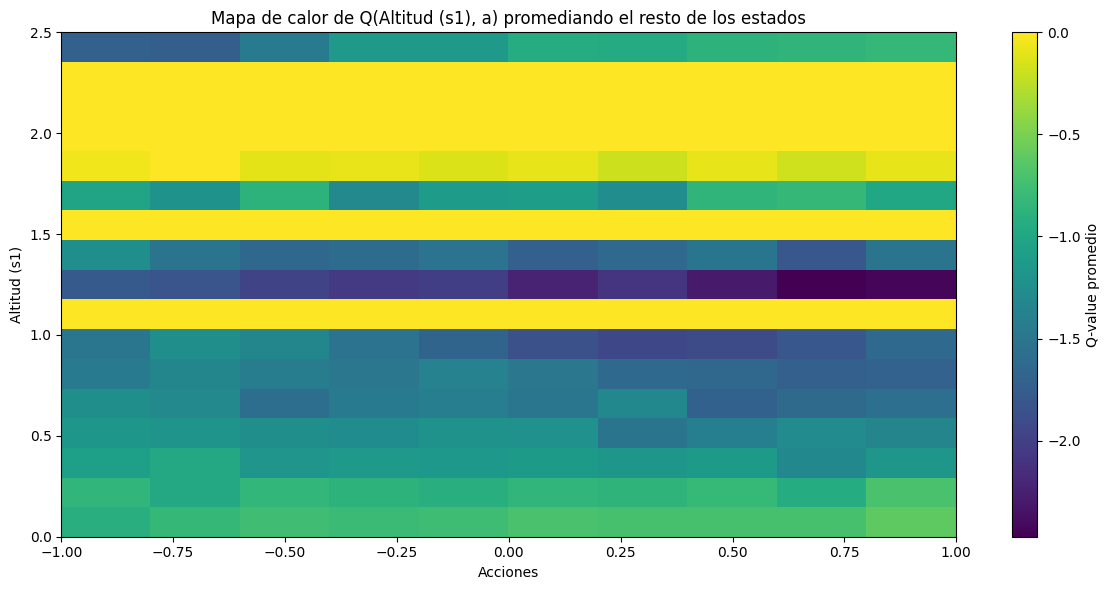

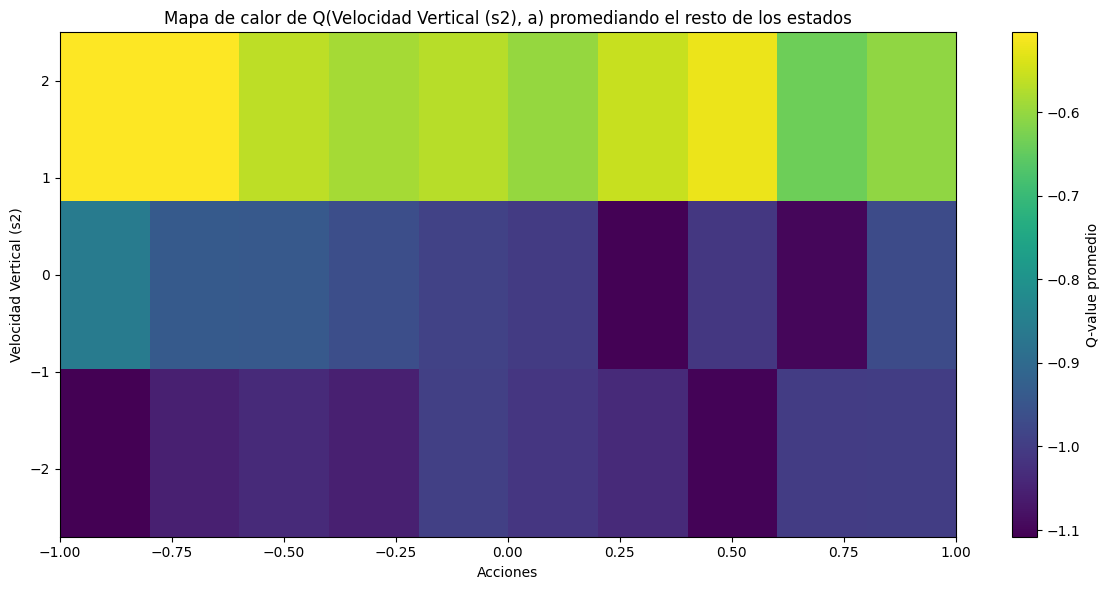

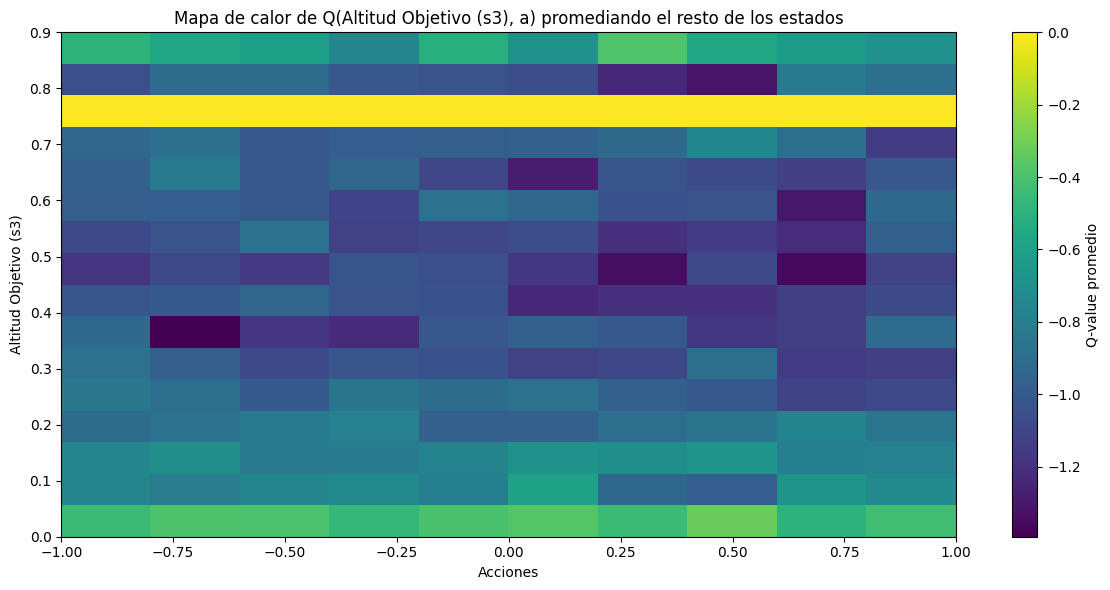

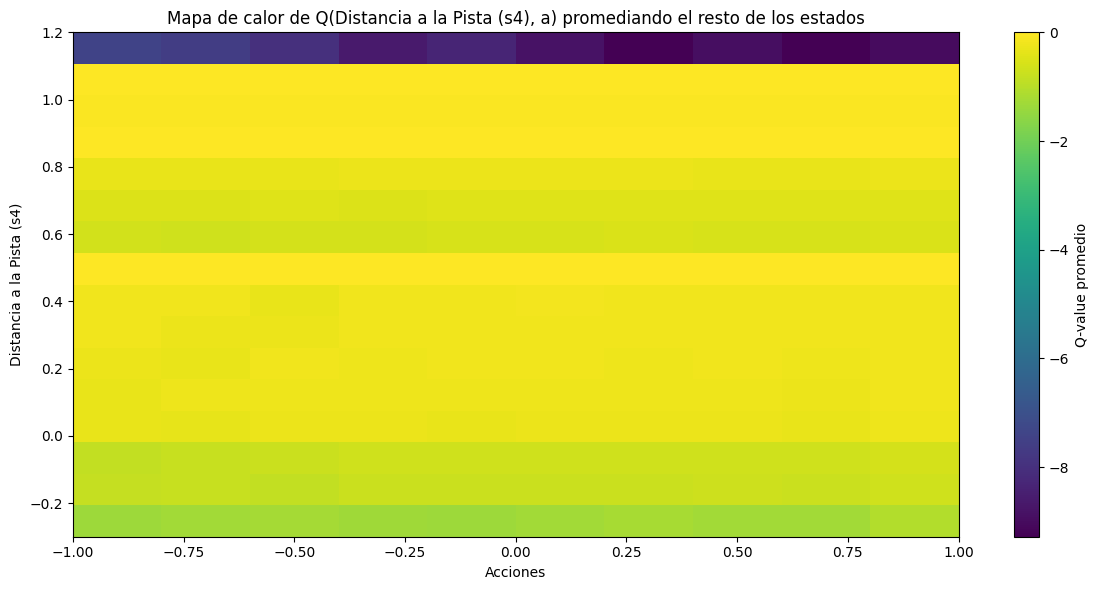

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_q_mean_heatmap_general(q_table, action_values, state_spaces, target_dim):
    """
    Calcula un mapa de calor de Q(s, a) promediado sobre las demás dimensiones.

    Args:
        q_table (np.ndarray): La tabla Q.
        action_values (list): Lista de valores de las acciones.
        state_spaces (list): Lista de espacios discretizados para cada dimensión (s1, s2, s3, s4).
        target_dim (int): Índice de la dimensión principal (0 para s1, 1 para s2, etc.).

    Returns:
        np.ndarray: Matriz de tamaño (len(state_spaces[target_dim]), len(action_values)) con los valores promedios.
    """
    heatmap = np.zeros((len(state_spaces[target_dim]), len(action_values)))
    other_dims = [i for i in range(len(state_spaces)) if i != target_dim]

    for target_index in range(len(state_spaces[target_dim])):
        for action_index in range(len(action_values)):
            q_sum = 0
            count = 0
            for indices in np.ndindex(*[len(state_spaces[dim]) for dim in other_dims]):
                full_index = [0] * len(state_spaces)
                full_index[target_dim] = target_index
                for i, dim in enumerate(other_dims):
                    full_index[dim] = indices[i]
                full_index.append(action_index)
                q_sum += q_table[tuple(full_index)]
                count += 1
            heatmap[target_index, action_index] = q_sum / count

    return heatmap

def plot_q_mean_heatmap_general(heatmap, state_space, action_values, state_label, title):
    """
    Grafica un mapa de calor para Q(s, a) promedio.

    Args:
        heatmap (np.ndarray): Matriz (s, a) con valores promedio.
        state_space (list): Valores discretizados para la dimensión principal.
        action_values (list): Lista de valores de las acciones.
        state_label (str): Etiqueta para la dimensión principal (e.g., "Altitud", "Velocidad Vertical").
        title (str): Título del gráfico.
    """
    plt.figure(figsize=(12, 6))
    im = plt.imshow(heatmap, aspect='auto', cmap='viridis', origin='lower',
                    extent=[action_values[0], action_values[-1], state_space[0], state_space[-1]])
    plt.colorbar(im, label="Q-value promedio")
    plt.xlabel("Acciones")
    plt.ylabel(state_label)
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Graficar mapas de calor para todas las dimensiones
dimensions = ["Altitud (s1)", "Velocidad Vertical (s2)", "Altitud Objetivo (s3)", "Distancia a la Pista (s4)"]
state_spaces = [altitude_space, vertical_velocity_space, target_altitude_space, runway_distance_space]

for target_dim, dimension_label in enumerate(dimensions):
    heatmap = calculate_q_mean_heatmap_general(
        q_table=agent.q,
        action_values=actions,
        state_spaces=state_spaces,
        target_dim=target_dim
    )
    plot_q_mean_heatmap_general(
        heatmap=heatmap,
        state_space=state_spaces[target_dim],
        action_values=actions,
        state_label=dimension_label,
        title=f"Mapa de calor de Q({dimension_label}, a) promediando el resto de los estados"
    )

In [9]:
average_reward = np.mean(rewards)
print(f"Promedio de recompensas: {average_reward}")

Promedio de recompensas: -83.3400663837214


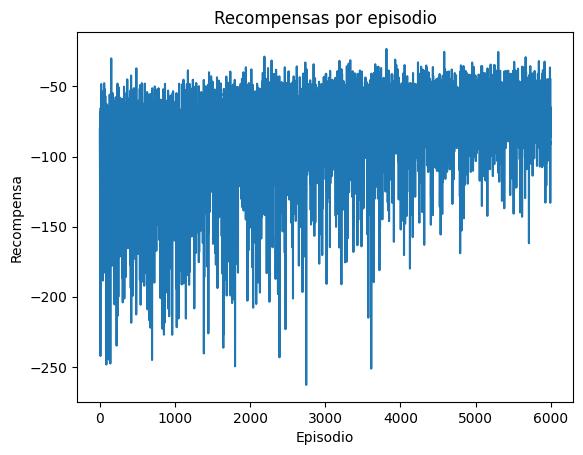

In [10]:
import matplotlib.pyplot as plt
plt.plot(rewards)
plt.xlabel('Episodio')
plt.ylabel('Recompensa')
plt.title('Recompensas por episodio')
plt.show()

In [11]:
test_rewards = agent.test_agent(env, episodes=500)
test_average_reward = np.mean(test_rewards)
print(f"Promedio de recompensas en test: {test_average_reward}")

Episode: 0, Reward: -63.48
Episode: 1, Reward: -79.14
Episode: 2, Reward: -62.63
Episode: 3, Reward: -72.01
Episode: 4, Reward: -74.93
Episode: 5, Reward: -54.38
Episode: 6, Reward: -59.36
Episode: 7, Reward: -72.65
Episode: 8, Reward: -51.53
Episode: 9, Reward: -41.01
Episode: 10, Reward: -38.41
Episode: 11, Reward: -51.04
Episode: 12, Reward: -39.28
Episode: 13, Reward: -63.23
Episode: 14, Reward: -71.97
Episode: 15, Reward: -38.55
Episode: 16, Reward: -48.78
Episode: 17, Reward: -60.58
Episode: 18, Reward: -63.83
Episode: 19, Reward: -56.27
Episode: 20, Reward: -53.81
Episode: 21, Reward: -56.30
Episode: 22, Reward: -70.22
Episode: 23, Reward: -63.40
Episode: 24, Reward: -38.47
Episode: 25, Reward: -54.63
Episode: 26, Reward: -68.06
Episode: 27, Reward: -56.39
Episode: 28, Reward: -67.97
Episode: 29, Reward: -55.20
Episode: 30, Reward: -49.07
Episode: 31, Reward: -46.10
Episode: 32, Reward: -76.27
Episode: 33, Reward: -49.91
Episode: 34, Reward: -51.56
Episode: 35, Reward: -51.33
Ep

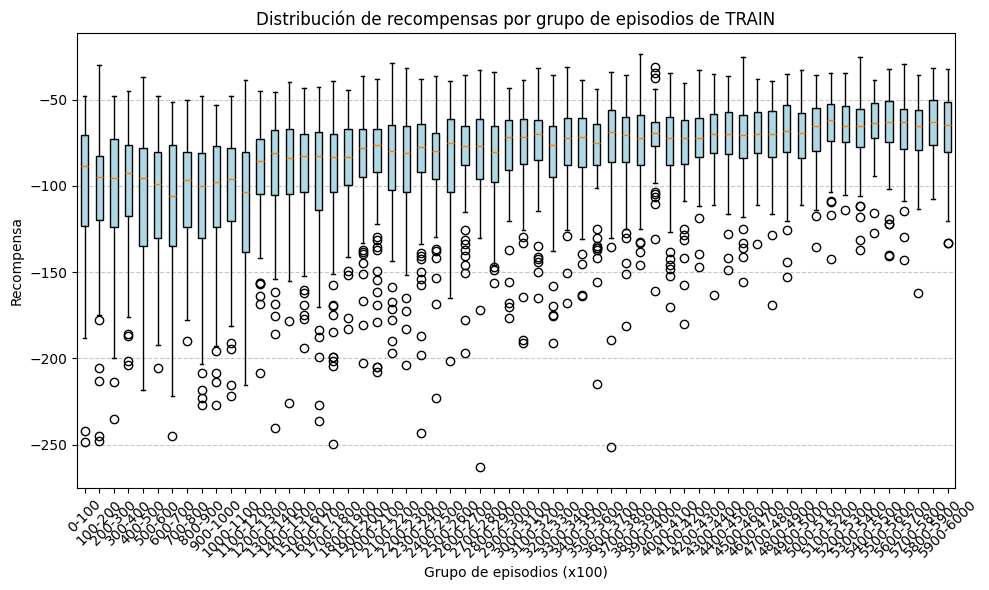

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Agrupar recompensas por intervalos de episodios
interval = 100  # Número de episodios por grupo
grouped_rewards = [rewards[i:i + interval] for i in range(0, len(rewards), interval)]

# Crear el boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_rewards, patch_artist=True, boxprops=dict(facecolor='lightblue'))

# Etiquetas y título
plt.xlabel('Grupo de episodios (x100)')
plt.ylabel('Recompensa')
plt.title('Distribución de recompensas por grupo de episodios de TRAIN')
plt.xticks(ticks=range(1, len(grouped_rewards) + 1), labels=[f'{i*interval}-{(i+1)*interval}' for i in range(len(grouped_rewards))], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

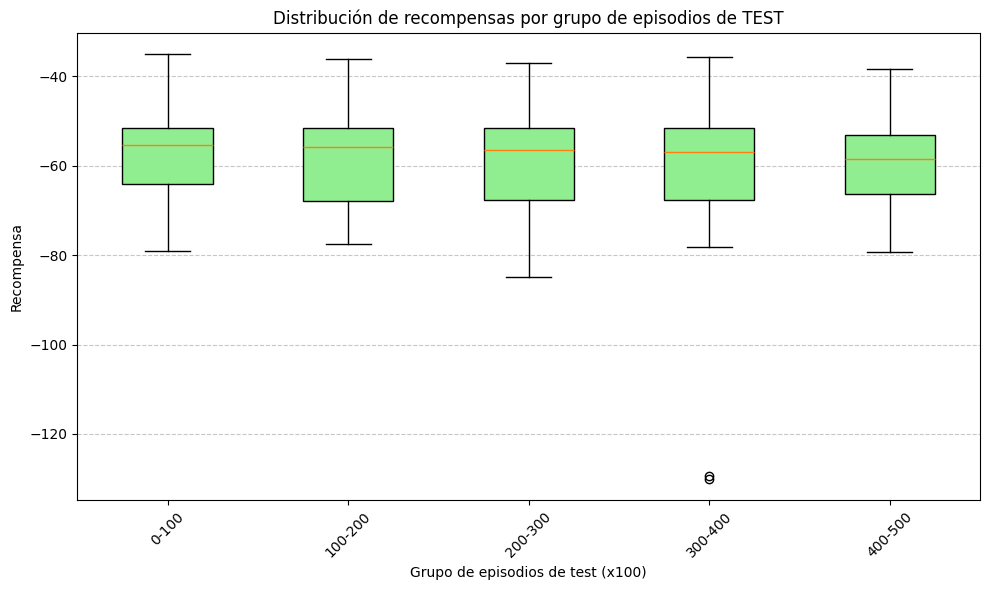

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Agrupar recompensas de test por intervalos de episodios
interval = 100  # Número de episodios por grupo
grouped_test_rewards = [test_rewards[i:i + interval] for i in range(0, len(test_rewards), interval)]

# Crear el boxplot para las recompensas de test
plt.figure(figsize=(10, 6))
plt.boxplot(grouped_test_rewards, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

# Etiquetas y título
plt.xlabel('Grupo de episodios de test (x100)')
plt.ylabel('Recompensa')
plt.title('Distribución de recompensas por grupo de episodios de TEST')
plt.xticks(ticks=range(1, len(grouped_test_rewards) + 1), labels=[f'{i*interval}-{(i+1)*interval}' for i in range(len(grouped_test_rewards))], rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [2]:
human_env = DescentEnv(render_mode="human")
agent.test_agent(human_env, episodes=10)

NameError: name 'DescentEnv' is not defined

In [15]:
wandb.login(key="b1666b9050a5ade20a5130837a3c3c5ac2e39580")
wandb.init(project="descent_env_training", name="training_run")
# Guardar hiperparámetros
wandb.config.update({
    "epsilon": epsilon,
    "gamma": gamma,
    "alpha": alpha,
    "episodes": episodes,
})

# Guardar discretización de los datos
wandb.log({
    "test_average_reward": test_average_reward
})
wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/agustinvarela/.netrc
wandb: Currently logged in as: agustinvarela2606 (artificial-inteligence-ort) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


wandb: ERROR The nbformat package was not found. It is required to save notebook history.


test_average_reward,▁
test_average_reward,-58.54046
